# Music Generation with RNNs

Building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in ABC notation and then use this model to generate new music. 

## Importing Dependencies 

In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

## Dataset
MITdeeplearning has a dataset of thousands of Irish folk songs, represented in the ABC notation. 


In [2]:
import mitdeeplearning as mdl

# Downloading the dataset
songs = mdl.lab1.load_training_data()

# Printing one of the songs to inspect it 
example_song = songs[2]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:3
T:Belfast
Z: id:dc-hornpipe-3
M:C|
L:1/8
K:D Major
ag|(3faf df AdFA|DFAd f2ef|gbec dfAF|GABG E2ag|!
(3faf df AdFA|DFAd f2ef|gbed cABc|d2f2 d2:|!
(3DEF|GFGA Bcde|fgfe dcdB|A2f2 fef2|G2e2 ede2|!
GFGA Bcde|fgfe dcdB|Afed cABc|d2f2 d2:|!
ag|(3fgf (3efe (3ded (3cdc|(3BcB (3ABA G2ba|(3gag (3fgf (3efe (3ded|(3cdc (3BcB A2ag|!
(3fgf (3efe (3ded (3cdc|(3BcB (3ABA (3GAG (3FGF|Eged cABc|d2f2 d2:|!


In [3]:
# Saving the ABC notation to a file as 'tmp.abc'
def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    with open(save_name, "w") as f:
        f.write(song)
    return filename

This notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo.

In [4]:
save_song_to_abc(example_song)

'tmp'

We can easily convert a song in ABC notation to an audio waveform and play it back. 

In [5]:
# Joining the list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


##  Processing the dataset 

We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

We'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters.

In [6]:
# Define numerical representation of text 

# Create a mapping from character to unique index.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters.
idx2char = np.array(vocab)
# This is the inverse of char2idx and allows us to convert back from unique index to the character in our vocabulary.

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's see this numerical representation of our dataset:

In [7]:
char2idx["a"]

56

In [8]:
idx2char[56]

'a'

In [9]:
# Vectorize the songs string 

def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

In [10]:
vectorized_songs

array([49, 22, 13, ..., 22, 82,  2])

## Create training examples and targets

Dividing the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain seq_length characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of seq_length+1. Suppose seq_length is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [11]:
# Batch definition to create training examples 

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]

  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

##  The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we had generated.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected Dense layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

We'll be using the Keras API, specifically, tf.keras.Sequential

* tf.keras.layers.Embedding: This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with embedding_dim dimensions.
* tf.keras.layers.LSTM: Our LSTM network, with size units=rnn_units. 
* tf.keras.layers.Dense: The output layer, with vocab_size outputs.



### Define the RNN model

In [12]:
# Defining the RNN Model 

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',recurrent_activation='sigmoid',stateful=True,),
    
    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size. 
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

#example model
model = build_model(len(vocab), embedding_dim=256, rnn_units=512, batch_size=32)

## Test out the RNN model

First, we can use the Model.summary function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 512)           1574912   
_________________________________________________________________
dense (Dense)                (32, None, 83)            42579     
Total params: 1,638,739
Trainable params: 1,638,739
Non-trainable params: 0
_________________________________________________________________


In [14]:
#checking the dimensionality of our input and output
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


## Training the model: loss and training operations

We can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character - that is, to actually predict the next character. 

To train our model on this classification task, we can use a form of the crossentropy loss (negative log likelihood loss). Specifically, we will use the sparse_categorical_crossentropy loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets - the labels - and the predicted targets - the logits.


In [15]:
# Defining the loss function 

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

### Hyperparameter setting and optimization

In [16]:
# Optimization parameters:
num_training_iterations = 1000   
seq_length = 100  
learning_rate = 5e-3  

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  
batch_size = 8

# Checkpoint location:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, defining our training operation - the optimizer and duration of training - and using this function to train the model. 

First, we will instantiate a new model and an optimizer. Then, we will use the tf.GradientTape method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

In [17]:
# Defining optimizer and training operation 

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  with tf.GradientTape() as tape:
  
    y_hat = model(x) 
  
    loss = compute_loss(y, y_hat) 

  # Computing the gradients
  grads = tape.gradient(loss, model.trainable_variables) 
  
  # Applying the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables)) 
  return loss

## Begin training

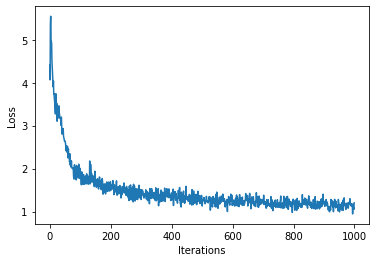

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [37:58<00:00,  2.28s/it]


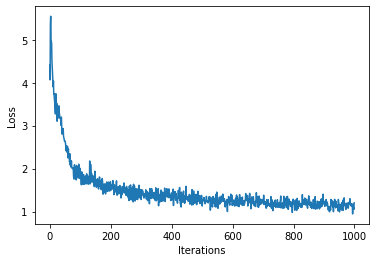

In [18]:
from tqdm import tqdm
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Generate music using the RNN model

Now, we can use our trained RNN model to generate some music. When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character using our trained RNN.

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different batch_size, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [19]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) 

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### The prediction procedure


* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

In [20]:
# Prediction of a generated song 

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  input_eval = [char2idx[s] for s in start_string] 
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id])  
    
  return (start_string + ''.join(text_generated))

In [25]:
generated_text = generate_text(model, start_string="X", generation_length=2000) 

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 147.77it/s]


### Saving the generated songs 

In [26]:
# Saving the generated songs 
import regex as re

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform =save_song_to_abc(song)


Found 9 songs in text
